# Amazon SageMaker Object Detection for Bird Species

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Data Preparation](#Data-Preparation)
  1. [Download and unpack the dataset](#Download-and-unpack-the-dataset)
  2. [Understand the dataset](#Understand-the-dataset)
  3. [Generate RecordIO files](#Generate-RecordIO-files)
4. [Train the model](#Train-the-model)
5. [Host the model](#Host-the-model)
6. [Test the model](#Test-the-model)
7. [Clean up](#Clean-up)
8. [Improve the model](#Improve-the-model)
9. [Final cleanup](#Final-cleanup)

## Introduction

Object detection is the process of identifying and localizing objects in an image. A typical object detection solution takes an image as input and provides a bounding box on the image where an object of interest is found.  It also identifies what type of object the box encapsulates.  To create such a solution, we need to acquire and process a traning dataset, create and setup a training job for the alorithm so that it can learn about the dataset. Finally, we can then host the trained model in an endpoint, to which we can supply images.

This notebook is an end-to-end example showing how the Amazon SageMaker Object Detection algorithm can be used with a publicly available dataset of bird images. We demonstrate how to train and to host an object detection model based on the [Caltech Birds (CUB 200 2011)](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset.  Amazon SageMaker's object detection algorithm uses the Single Shot multibox Detector ([SSD](https://arxiv.org/abs/1512.02325)) algorithm, and this notebook uses a [ResNet](https://arxiv.org/pdf/1603.05027.pdf) base network with that algorithm.

![Sample results detecting a pair of goldfinch on a feeder](./goldfinch_detections.png)

We will also demonstrate how to construct a training dataset using the RecordIO format, as this is the format that the training job consumes.  This notebook is similar to the [Object Detection using the RecordIO format](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb) notebook, with the following key differences:

- We provide an example of how to translate bounding box specifications when providing images to SageMaker's algorithm. You will see code for generating the train.lst and val.lst files used to create [recordIO](https://mxnet.incubator.apache.org/architecture/note_data_loading.html) files.
- We demonstrate how to improve an object detection model by adding training images that are flipped horizontally (mirror images).
- We give you a notebook for experimenting with object detection challenges with an order of magnitude more classes (200 bird species, as opposed to the 20 categories used by [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/)).
- We show how to chart the accuracy improvements that occur across the epochs of the training job.

Note that Amazon SageMaker Object Detection also allows training with the image and JSON format, which is illustrated in the [image and JSON Notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_image_json_format.ipynb).

## Setup

Before preparing the data, there are some initial steps required for setup.


This notebook requires two additional Python packages:
* **OpenCV** is required for gathering image sizes and flipping of images horizontally.
* The **MXnet** runtime is required for using the im2rec tool.

In [1]:
import sys
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install mxnet

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


We need to identify the S3 bucket that you want to use for providing training and validation datasets.  It will also be used to store the tranied model artifacts. In this notebook, we use a custom bucket. You could alternatively use a default bucket for the session.  We use an object prefix to help organize the bucket content.

In [2]:
bucket = '<your_s3_bucket_name_here>' # custom bucket name.
bucket='roymark-aws-ml'  ## REMOVE THIS LINE BEFORE PUBLISHING
prefix = 'DEMO-ObjectDetection-birds'

To train the Object Detection algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with, we need an AWS account role with SageMaker access. This role is used to give SageMaker access to your data in S3.  Here we obtain the role that was used to start the notebook instance.

In [3]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::355151823911:role/service-role/AmazonSageMaker-ExecutionRole-20180515T132694


Lastly, we need the Amazon SageMaker Object Detection docker image, which is static.

In [4]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:latest


# Data Preparation

The [Caltech Birds (CUB 200 2011)](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset contains 11,788 images across 200 bird species (the original technical report can be found [here](http://www.vision.caltech.edu/visipedia/papers/CUB_200_2011.pdf)).  Each species comes with around 60 images, with a typical size of about 350 pixels by 500 pixels.  Bounding boxes are provided, as are annotations of bird parts.  A recommended train/test split is given, but image size data is not.

![](./cub_200_2011_snapshot.png)

The dataset can be downloaded [here](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html).

## Download and unpack the dataset

Here we download the birds dataset from CalTech.

In [5]:
import os 
import urllib.request

def download(url):
    filename = url.split('/')[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

In [6]:
%%time
download('http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz')

CPU times: user 2.6 s, sys: 2.01 s, total: 4.61 s
Wall time: 4min 29s


Now we unpack the dataset into its own directory structure.

In [7]:
%%time
!rm -rf CUB_200_2011  # clean up prior version if running again

!gunzip -c ./CUB_200_2011.tgz | tar xopf - 
!rm CUB_200_2011.tgz

CPU times: user 218 ms, sys: 32.3 ms, total: 251 ms
Wall time: 13.7 s


# Understand the dataset

## Set some parameters for the rest of the notebook to use

Here we define a few parameters that help drive the rest of the notebook.  For example, `SAMPLE_ONLY` is defaulted to `True`. This will force the notebook to train on only a handful of species.  Setting to false will make the notebook work with the entire dataset of 200 bird species.  This makes the training a more difficult challenge, and you will need many more epochs to complete.

The file parameters define names and locations of metadata files for the dataset.

In [8]:
import pandas as pd
import cv2
import boto3
import json

runtime = boto3.client(service_name='runtime.sagemaker')

import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SPLIT = False
SAMPLE_ONLY  = True
FLIP         = False

# To speed up training and experimenting, you can use a small handful of species.
# To see the full list of the classes available, look at the content of CLASSES_FILE.
CLASSES = [17, 36, 47, 68, 73]

# Otherwise, you can use the full set of species
if (not SAMPLE_ONLY):
    CLASSES = []
    for c in range(200):
        CLASSES += [c + 1]

RESIZE_SIZE = 256

BASE_DIR   = 'CUB_200_2011/'
IMAGES_DIR = BASE_DIR + 'images/'

CLASSES_FILE = BASE_DIR + 'classes.txt'
BBOX_FILE    = BASE_DIR + 'bounding_boxes.txt'
IMAGE_FILE   = BASE_DIR + 'images.txt'
LABEL_FILE   = BASE_DIR + 'image_class_labels.txt'
SIZE_FILE    = BASE_DIR + 'sizes.txt'
SPLIT_FILE   = BASE_DIR + 'train_test_split.txt'

TRAIN_LST_FILE = 'birds_ssd_train.lst'
VAL_LST_FILE   = 'birds_ssd_val.lst'

if (SAMPLE_ONLY):
    TRAIN_LST_FILE = 'birds_ssd_sample_train.lst'
    VAL_LST_FILE   = 'birds_ssd_sample_val.lst'

TRAIN_RATIO     = 0.8
CLASS_COLS      = ['class_number','class_id']
IM2REC_SSD_COLS = ['header_cols', 'label_width', 'zero_based_id', 'xmin', 'ymin', 'xmax', 'ymax', 'image_file_name']

## Explore the dataset images

For each species, there are dozens of images of various shapes and sizes. By dividing the entire dataset into individual named (numbered) folders, the images are in effect labelled for supervised learning using image classification and object detection algorithms. 

The following function displays a grid of thumbnail images for all the image files for a given species.

In [9]:
def show_species(species_id):
    _im_list = !ls $IMAGES_DIR/$species_id

    NUM_COLS = 6
    IM_COUNT = len(_im_list)

    print('Species ' + species_id + ' has ' + str(IM_COUNT) + ' images.')
    
    NUM_ROWS = int(IM_COUNT / NUM_COLS)
    if ((IM_COUNT % NUM_COLS) > 0):
        NUM_ROWS += 1

    fig, axarr = plt.subplots(NUM_ROWS, NUM_COLS)
    fig.set_size_inches(8.0, 16.0, forward=True)

    curr_row = 0
    for curr_img in range(IM_COUNT):
        # fetch the url as a file type object, then read the image
        f = IMAGES_DIR + species_id + '/' + _im_list[curr_img]
        a = plt.imread(f)

        # find the column by taking the current index modulo 3
        col = curr_img % NUM_ROWS
        # plot on relevant subplot
        axarr[col, curr_row].imshow(a)
        if col == (NUM_ROWS - 1):
            # we have finished the current row, so increment row counter
            curr_row += 1

    fig.tight_layout()       
    plt.show()
        
    # Clean up
    plt.clf()
    plt.cla()
    plt.close()

Show the list of bird species or dataset classes.

In [10]:
classes_df = pd.read_csv(CLASSES_FILE, sep=' ', names=CLASS_COLS, header=None)
criteria = classes_df['class_number'].isin(CLASSES)
classes_df = classes_df[criteria]
print(classes_df.to_csv(columns=['class_id'], sep='\t', index=False, header=False))

017.Cardinal
036.Northern_Flicker
047.American_Goldfinch
068.Ruby_throated_Hummingbird
073.Blue_Jay



Now for any given species, display thumbnail images of each of the images provided for training and testing.

Species 017.Cardinal has 57 images.


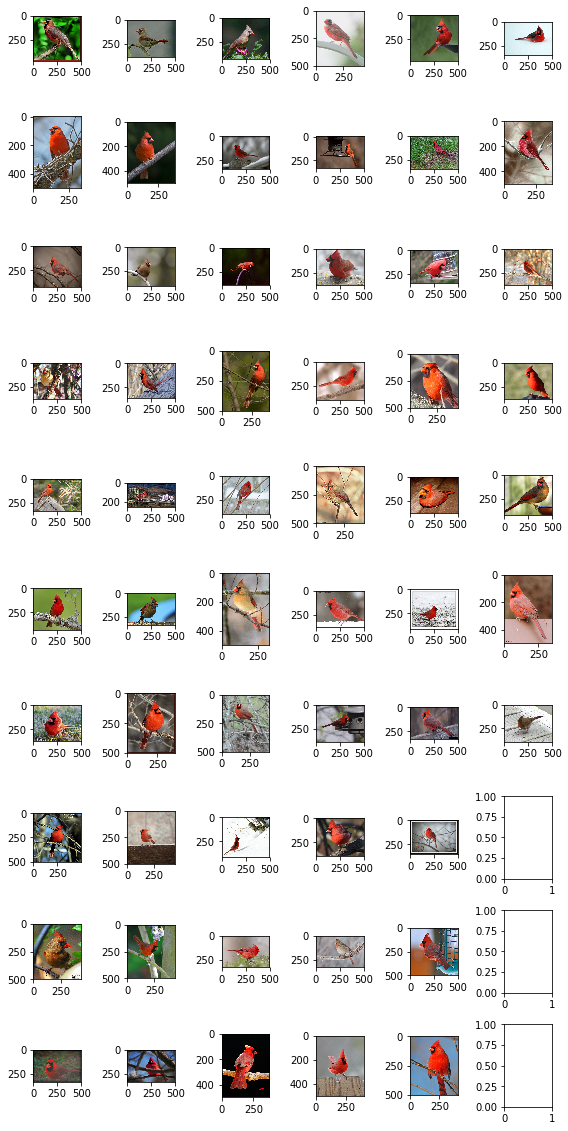

In [11]:
show_species('017.Cardinal')

# Generate RecordIO files

## Step 1. Gather image sizes

For this particular dataset, bounding box annotations are specified in absolute terms.  RecordIO format requires them to be defined in terms relative to the image size.  The following code visits each image, extracts the height and width, and saves this information into a file for subsequent use.  Some other publicly available datasets provide such a file for exactly this purpose. 

In [12]:
%%time
SIZE_COLS = ['idx','width','height']

def gen_image_size_file():
    print('Generating a file containing image sizes...')
    images_df = pd.read_csv(IMAGE_FILE, sep=' ',
                            names=['image_pretty_name', 'image_file_name'],
                            header=None)
    rows_list = []
    idx = 0
    for i in images_df['image_file_name']:
        # TODO: add progress bar
        idx += 1
        img = cv2.imread(IMAGES_DIR + i)
        dimensions = img.shape
        height = img.shape[0]
        width = img.shape[1]
        image_dict = {'idx': idx, 'width': width, 'height': height}
        rows_list.append(image_dict)

    sizes_df = pd.DataFrame(rows_list)
    print('Image sizes:\n' + str(sizes_df.head()))

    sizes_df[SIZE_COLS].to_csv(SIZE_FILE, sep=' ', index=False, header=None)

gen_image_size_file()

Generating a file containing image sizes...
Image sizes:
   height  idx  width
0     335    1    500
1     336    2    500
2     347    3    500
3     500    4    415
4     380    5    331
CPU times: user 37.7 s, sys: 177 ms, total: 37.9 s
Wall time: 38 s


## Step 2. Generate list files for producing RecordIO files 

[RecordIO](https://mxnet.incubator.apache.org/architecture/note_data_loading.html) files can be created using the [im2rec tool](https://mxnet.incubator.apache.org/faq/recordio.html) (images to RecordIO), which takes as input a pair of list files, one for training images and the other for validation images.  Each list file has one row for each image.  For object detection, each row must contain bounding box data and a class label.

For the CalTech birds dataset, we need to convert absolute bounding box dimensions to relative dimensions based on image size.  We also need to adjust class id's to be zero-based (instead of 1 to 200, they need to be 0 to 199).  This  dataset comes with recommended train/test split information ("is_training_image" flag).  This notebook is built flexibly to either leverage this suggestion, or to create a random train/test split with a specific train/test ratio.  The `RAMDOM_SPLIT` variable defined earlier controls whether or not the split happens randomly.

In [13]:
def split_to_train_test(df, label_column, train_frac=0.8):
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    labels = df[label_column].unique()
    for lbl in labels:
        lbl_df = df[df[label_column] == lbl]
        lbl_train_df = lbl_df.sample(frac=train_frac)
        lbl_test_df = lbl_df.drop(lbl_train_df.index)
        print('\n{}:\n---------\ntotal:{}\ntrain_df:{}\ntest_df:{}'.format(lbl, len(lbl_df), len(lbl_train_df), len(lbl_test_df)))
        train_df = train_df.append(lbl_train_df)
        test_df = test_df.append(lbl_test_df)
    return train_df, test_df

def gen_list_files():
    # use generated sizes file
    sizes_df = pd.read_csv(SIZE_FILE, sep=' ',
                names=['image_pretty_name', 'width', 'height'],
                header=None)
    bboxes_df = pd.read_csv(BBOX_FILE, sep=' ',
                names=['image_pretty_name', 'x_abs', 'y_abs', 'bbox_width', 'bbox_height'],
                header=None)
    split_df = pd.read_csv(SPLIT_FILE, sep=' ',
                            names=['image_pretty_name', 'is_training_image'],
                            header=None)
    print(IMAGE_FILE)
    images_df = pd.read_csv(IMAGE_FILE, sep=' ',
                            names=['image_pretty_name', 'image_file_name'],
                            header=None)
    print('num images total: ' + str(images_df.shape[0]))
    image_class_labels_df = pd.read_csv(LABEL_FILE, sep=' ',
                                names=['image_pretty_name', 'class_id'], header=None)

    # Merge the metadata into a single flat dataframe for easier processing
    full_df = pd.DataFrame(images_df)
    full_df.reset_index(inplace=True)
    full_df = pd.merge(full_df, image_class_labels_df, on='image_pretty_name')
    full_df = pd.merge(full_df, sizes_df, on='image_pretty_name')
    full_df = pd.merge(full_df, bboxes_df, on='image_pretty_name')
    full_df = pd.merge(full_df, split_df, on='image_pretty_name')
    full_df.sort_values(by=['index'], inplace=True)

    # Define the bounding boxes in the format required by SageMaker's built in Object Detection algorithm.
    # the xmin/ymin/xmax/ymax parameters are specified as ratios to the total image pixel size
    full_df['header_cols'] = 2  # one col for the number of header cols, one for the label width
    full_df['label_width'] = 5  # number of cols for each label: class, xmin, ymin, xmax, ymax
    full_df['xmin'] = full_df['x_abs'] / full_df['width']
    full_df['xmax'] = (full_df['x_abs'] + full_df['bbox_width']) / full_df['width']
    full_df['ymin'] = full_df['y_abs'] / full_df['height']
    full_df['ymax'] = (full_df['y_abs'] + full_df['bbox_height']) / full_df['height']

    # object detection class id's must be zero based. map from
    # class_id's given by CUB to zero-based (1 is 0, and 200 is 199).

    if SAMPLE_ONLY:
        # grab a small subset of species for testing
        criteria = full_df['class_id'].isin(CLASSES)
        full_df = full_df[criteria]

    unique_classes = full_df['class_id'].drop_duplicates()
    sorted_unique_classes = sorted(unique_classes)

    id_to_zero = {}
    i = 0.0
    for c in sorted_unique_classes:
        id_to_zero[c] = i
        i += 1.0

    full_df['zero_based_id'] = full_df['class_id'].map(id_to_zero)

    full_df.reset_index(inplace=True)

    # use 4 decimal places, as it seems to be required by the Object Detection algorithm
    pd.set_option("display.precision", 4)

    train_df = []
    val_df = []

    if (RANDOM_SPLIT):
        # split into training and validation sets
        train_df, val_df = split_to_train_test(full_df, 'class_id', TRAIN_RATIO)

        train_df[IM2REC_SSD_COLS].to_csv(TRAIN_LST_FILE, sep='\t',
                float_format='%.4f', header=None)
        val_df[IM2REC_SSD_COLS].to_csv(  VAL_LST_FILE, sep='\t',
                float_format='%.4f', header=None)
    else:
        train_df = full_df[(full_df.is_training_image == 1)]
        train_df[IM2REC_SSD_COLS].to_csv(TRAIN_LST_FILE, sep='\t',
                float_format='%.4f', header=None)

        val_df = full_df[(full_df.is_training_image == 0)]
        val_df[IM2REC_SSD_COLS].to_csv(  VAL_LST_FILE, sep='\t',
                float_format='%.4f', header=None)
        
    print('num train: ' + str(train_df.shape[0]))
    print('num val: ' + str(val_df.shape[0]))
    return train_df, val_df

In [14]:
train_df, val_df = gen_list_files()

CUB_200_2011/images.txt
num images total: 11788
num train: 150
num val: 147


Here we take a look at a few records from the training list file to understand better what is being fed to the RecordIO files.

The first column is the image number or index.  The second column indicates that the label is made up of 2 columns (column 2 and column 3).  The third column specifies the label width of a single object. In our case, the value 5 indicates each image has 5 numbers to describe its label information: the class index, and the 4 bounding box coordinates. If there are multiple objects within one image, all the label information should be listed in one line. Our dataset contains only one bounding box per image.

The fourth column is the class label.  This identifies the bird species using a zero-based class id.  Columns 4 through 7 represent the bounding box for where the bird is found in this image.

The classes should be labeled with successive numbers and start with 0. The bounding box coordinates are ratios of its top-left (xmin, ymin) and bottom-right (xmax, ymax) corner indices to the overall image size. Note that the top-left corner of the entire image is the origin (0, 0). The last column specifies the relative path of the image file within the images directory.

In [15]:
!tail -3 $TRAIN_LST_FILE

291	2	5	4.0000	0.4080	0.1527	0.9880	0.8728	073.Blue_Jay/Blue_Jay_0048_62433.jpg
294	2	5	4.0000	0.2500	0.1455	0.8260	0.8303	073.Blue_Jay/Blue_Jay_0086_63394.jpg
296	2	5	4.0000	0.2960	0.5400	0.8160	0.8460	073.Blue_Jay/Blue_Jay_0074_63487.jpg


## Step 2. Convert data into RecordIO format

Now we create im2rec databases (.rec files) for training and validation based on the list files created earlier.

In [16]:
!python tools/im2rec.py --resize $RESIZE_SIZE --pack-label birds_ssd_sample $BASE_DIR/images/

Creating .rec file from /home/ec2-user/SageMaker/birds_ssd_sample_train.lst in /home/ec2-user/SageMaker
multiprocessing not available, fall back to single threaded encoding
time: 0.006155252456665039  count: 0
Creating .rec file from /home/ec2-user/SageMaker/birds_ssd_sample_val.lst in /home/ec2-user/SageMaker
multiprocessing not available, fall back to single threaded encoding
time: 0.005446910858154297  count: 0


## Step 3. Upload RecordIO files to S3
Upload the training and validation data to the S3 bucket. We do this in multiple channels. Channels are simply directories in the bucket that differentiate the types of data provided to the algorithm. For the object detection algorithm, we call these directories `train` and `validation`.

In [17]:
# Upload the RecordIO files to train and validation channels
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sess.upload_data(path='birds_ssd_sample_train.rec', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='birds_ssd_sample_val.rec', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

# Train the model

Next we define an output location in S3, where the model artifacts will be placed on completion of the training. These artifacts are the output of the algorithm's traning job.

In [18]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [19]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

## Define hyperparameters

The object detection algorithm at its core is the [Single-Shot Multi-Box detection algorithm (SSD)](https://arxiv.org/abs/1512.02325). This algorithm uses a `base_network`, which is typically a [VGG](https://arxiv.org/abs/1409.1556) or a [ResNet](https://arxiv.org/abs/1512.03385). The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50. It also has a number of hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model. See the SageMaker Object Detection [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html) for more details on the hyperparameters.

One of the hyperparameters here for example is `epochs`. This defines how many passes of the dataset we iterate over and drives the training time of the algorithm. Based on our tests, we can achieve 70% accuracy on a sample mix of 5 species with 100 epochs.  When using the full 200 species, we can achieve 52% accuracy with 1,200 epochs.

In [20]:
def set_hyperparameters(num_epochs, lr_steps):
    num_classes = classes_df.shape[0]
    num_training_samples = train_df.shape[0]
    print('num classes: {}, num training images: {}'.format(num_classes, num_training_samples))

    od_model.set_hyperparameters(base_network='resnet-50',
                                 use_pretrained_model=1,
                                 num_classes=num_classes,
                                 mini_batch_size=16,
                                 epochs=num_epochs,               
                                 learning_rate=0.001, 
                                 lr_scheduler_step=lr_steps,      
                                 lr_scheduler_factor=0.1,
                                 optimizer='sgd',
                                 momentum=0.9,
                                 weight_decay=0.0005,
                                 overlap_threshold=0.5,
                                 nms_threshold=0.45,
                                 image_shape=512,
                                 label_width=350,
                                 num_training_samples=num_training_samples)

In [21]:
set_hyperparameters(100, '33,67')

num classes: 5, num training images: 150


Now that the hyperparameters are setup, we define the data channels to be passed to the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.  Note that you could add a third channel named `model` to perform incremental training (continue training from where you had left off with a prior model).

In [22]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='application/x-recordio', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

## Submit training job

We have our `Estimator` object, we have set the hyperparameters for this object, and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm using the `fit` method. This will take more than 10 minutes in our example.

The training process involves a few steps. First, the instances that we requested while creating the `Estimator` classes are provisioned and setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the actual training begins. The provisioning and data downloading will take time, depending on the size of the data. Therefore it might be a few minutes before we start seeing log entries for our training jobs. The data logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset (once per epoch). This metric is a proxy for the quality of the algorithm.

Once the job has finished, a `Job complete` message will be printed. The trained model artifacts can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [23]:
%%time
od_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: object-detection-2019-01-20-15-19-31-100


2019-01-20 15:19:31 Starting - Starting the training job...
2019-01-20 15:19:34 Starting - Launching requested ML instances......
2019-01-20 15:20:42 Starting - Preparing the instances for training......
2019-01-20 15:21:51 Downloading - Downloading input data...
2019-01-20 15:22:03 Training - Downloading the training image...
2019-01-20 15:22:47 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[01/20/2019 15:22:49 INFO 139784023504704] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentu

[01/20/2019 15:23:21 INFO 139784023504704] #quality_metric: host=algo-1, epoch=2, validation mAP <score>=(0.000101190505551)
[01/20/2019 15:23:21 INFO 139784023504704] Updating the best model with validation-mAP=0.000101190505551
[01/20/2019 15:23:21 INFO 139784023504704] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[01/20/2019 15:23:21 INFO 139784023504704] #progress_metric: host=algo-1, completed 3 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Reset Count": {"count": 1, "max": 3, "sum": 3.0, "min": 3}}, "EndTime": 1547997

[01/20/2019 15:23:51 INFO 139784023504704] #quality_metric: host=algo-1, epoch=9, validation mAP <score>=(0.0017796444836)
[01/20/2019 15:23:51 INFO 139784023504704] #progress_metric: host=algo-1, completed 10 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Reset Count": {"count": 1, "max": 10, "sum": 10.0, "min": 10}}, "EndTime": 1547997831.283958, "Dimensions": {"Host": "algo-1", "Meta": "training_data_iter", "Operation": "training", "Algorithm": "AWS/Object Detection", "epoch": 9}, "StartTime": 1547997827.139681}

[01/20/2019 15:23:53 WAR

[01/20/2019 15:24:19 WARNING 139784023504704] Expected number of batches: 9, did not match the number of batches processed: 10. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:24:19 INFO 139784023504704] #quality_metric: host=algo-1, epoch=16, batch=10 train cross_entropy <loss>=(1.54838765557)
[01/20/2019 15:24:19 INFO 139784023504704] #quality_metric: host=algo-1, epoch=16, batch=10 train smooth_l1 <loss>=(0.61316058529)
[01/20/2019 15:24:19 INFO 139784023504704] Round of batches complete
[01/20/2019 15:24:19 INFO 139784023504704] Updated the metrics
[01/20/2019 15:24:21 INFO 139784023504704] #quality_metric: host=algo-1, epoch=16, validation mAP <score>=(0.0180710412693)
[01/20/2019 15:24:21 INFO 139784023504704] #progress_metric: host=algo-1, completed 17 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.

[01/20/2019 15:24:50 INFO 139784023504704] #quality_metric: host=algo-1, epoch=23, validation mAP <score>=(0.0669054661182)
[01/20/2019 15:24:50 INFO 139784023504704] Updating the best model with validation-mAP=0.0669054661182
[01/20/2019 15:24:50 INFO 139784023504704] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[01/20/2019 15:24:50 INFO 139784023504704] #progress_metric: host=algo-1, completed 24 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Reset Count": {"count": 1, "max": 24, "sum": 24.0, "min": 24}}, "EndTime": 154799

[01/20/2019 15:25:14 WARNING 139784023504704] Expected number of batches: 9, did not match the number of batches processed: 10. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:25:14 INFO 139784023504704] #quality_metric: host=algo-1, epoch=29, batch=10 train cross_entropy <loss>=(1.07512075544)
[01/20/2019 15:25:14 INFO 139784023504704] #quality_metric: host=algo-1, epoch=29, batch=10 train smooth_l1 <loss>=(0.565415659606)
[01/20/2019 15:25:14 INFO 139784023504704] Round of batches complete
[01/20/2019 15:25:14 INFO 139784023504704] Updated the metrics
[01/20/2019 15:25:16 INFO 139784023504704] #quality_metric: host=algo-1, epoch=29, validation mAP <score>=(0.132472556845)
[01/20/2019 15:25:16 INFO 139784023504704] Updating the best model with validation-mAP=0.132472556845
[01/20/2019 15:25:16 INFO 139784023504704] Saved checkpoint to "/opt/ml/model/model_al

[01/20/2019 15:25:39 INFO 139784023504704] #quality_metric: host=algo-1, epoch=35, batch=9 train cross_entropy <loss>=(0.976534111194)
[01/20/2019 15:25:39 INFO 139784023504704] #quality_metric: host=algo-1, epoch=35, batch=9 train smooth_l1 <loss>=(0.532794517315)
[01/20/2019 15:25:39 INFO 139784023504704] Round of batches complete
[01/20/2019 15:25:39 INFO 139784023504704] Updated the metrics
[01/20/2019 15:25:40 INFO 139784023504704] #quality_metric: host=algo-1, epoch=35, validation mAP <score>=(0.165896384804)
[01/20/2019 15:25:40 INFO 139784023504704] #progress_metric: host=algo-1, completed 36 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max":

[01/20/2019 15:26:00 INFO 139784023504704] Updated the metrics
[01/20/2019 15:26:01 INFO 139784023504704] #quality_metric: host=algo-1, epoch=40, validation mAP <score>=(0.178669210367)
[01/20/2019 15:26:01 INFO 139784023504704] #progress_metric: host=algo-1, completed 41 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Reset Count": {"count": 1, "max": 41, "sum": 41.0, "min": 41}}, "EndTime": 1547997961.671242, "Dimensions": {"Host": "algo-1", "Meta": "training_data_iter", "Operation": "training", "Algorithm": "AWS/Object Detection", "epoch"

[01/20/2019 15:26:24 INFO 139784023504704] #quality_metric: host=algo-1, epoch=46, batch=9 train cross_entropy <loss>=(0.897069726601)
[01/20/2019 15:26:24 INFO 139784023504704] #quality_metric: host=algo-1, epoch=46, batch=9 train smooth_l1 <loss>=(0.474901753087)
[01/20/2019 15:26:24 INFO 139784023504704] Round of batches complete
[01/20/2019 15:26:24 INFO 139784023504704] Updated the metrics
[01/20/2019 15:26:25 INFO 139784023504704] #quality_metric: host=algo-1, epoch=46, validation mAP <score>=(0.16911607884)
[01/20/2019 15:26:25 INFO 139784023504704] #progress_metric: host=algo-1, completed 47 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 

[01/20/2019 15:26:53 WARNING 139784023504704] Expected number of batches: 9, did not match the number of batches processed: 10. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:26:53 INFO 139784023504704] #quality_metric: host=algo-1, epoch=53, batch=10 train cross_entropy <loss>=(0.908160269148)
[01/20/2019 15:26:53 INFO 139784023504704] #quality_metric: host=algo-1, epoch=53, batch=10 train smooth_l1 <loss>=(0.460993883966)
[01/20/2019 15:26:53 INFO 139784023504704] Round of batches complete
[01/20/2019 15:26:53 INFO 139784023504704] Updated the metrics
[01/20/2019 15:26:54 INFO 139784023504704] #quality_metric: host=algo-1, epoch=53, validation mAP <score>=(0.183934629848)
[01/20/2019 15:26:54 INFO 139784023504704] #progress_metric: host=algo-1, completed 54 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0

[01/20/2019 15:27:21 INFO 139784023504704] #quality_metric: host=algo-1, epoch=60, batch=9 train cross_entropy <loss>=(0.878752603369)
[01/20/2019 15:27:21 INFO 139784023504704] #quality_metric: host=algo-1, epoch=60, batch=9 train smooth_l1 <loss>=(0.437180244316)
[01/20/2019 15:27:21 INFO 139784023504704] Round of batches complete
[01/20/2019 15:27:22 INFO 139784023504704] Updated the metrics
[01/20/2019 15:27:23 INFO 139784023504704] #quality_metric: host=algo-1, epoch=60, validation mAP <score>=(0.320727081926)
[01/20/2019 15:27:23 INFO 139784023504704] #progress_metric: host=algo-1, completed 61 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max":

[01/20/2019 15:27:44 INFO 139784023504704] #quality_metric: host=algo-1, epoch=65, validation mAP <score>=(0.286066612973)
[01/20/2019 15:27:44 INFO 139784023504704] #progress_metric: host=algo-1, completed 66 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Reset Count": {"count": 1, "max": 66, "sum": 66.0, "min": 66}}, "EndTime": 1547998064.26073, "Dimensions": {"Host": "algo-1", "Meta": "training_data_iter", "Operation": "training", "Algorithm": "AWS/Object Detection", "epoch": 65}, "StartTime": 1547998060.362071}

[01/20/2019 15:27:47 WAR

[01/20/2019 15:28:15 INFO 139784023504704] #quality_metric: host=algo-1, epoch=73, batch=9 train cross_entropy <loss>=(0.844267185529)
[01/20/2019 15:28:15 INFO 139784023504704] #quality_metric: host=algo-1, epoch=73, batch=9 train smooth_l1 <loss>=(0.414111439387)
[01/20/2019 15:28:15 INFO 139784023504704] Round of batches complete
[01/20/2019 15:28:15 INFO 139784023504704] Updated the metrics
[01/20/2019 15:28:17 INFO 139784023504704] #quality_metric: host=algo-1, epoch=73, validation mAP <score>=(0.523224606099)
[01/20/2019 15:28:17 INFO 139784023504704] Updating the best model with validation-mAP=0.523224606099
[01/20/2019 15:28:17 INFO 139784023504704] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[01/20/2019 15:28:17 INFO 139784023504704] #progress_metric: host=algo-1, completed 74 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0

[01/20/2019 15:28:44 WARNING 139784023504704] Expected number of batches: 9, did not match the number of batches processed: 10. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:28:44 INFO 139784023504704] #quality_metric: host=algo-1, epoch=80, batch=10 train cross_entropy <loss>=(0.839289095199)
[01/20/2019 15:28:44 INFO 139784023504704] #quality_metric: host=algo-1, epoch=80, batch=10 train smooth_l1 <loss>=(0.386580611775)
[01/20/2019 15:28:44 INFO 139784023504704] Round of batches complete
[01/20/2019 15:28:44 INFO 139784023504704] Updated the metrics
[01/20/2019 15:28:46 INFO 139784023504704] #quality_metric: host=algo-1, epoch=80, validation mAP <score>=(0.623456298645)
[01/20/2019 15:28:46 INFO 139784023504704] Updating the best model with validation-mAP=0.623456298645
[01/20/2019 15:28:46 INFO 139784023504704] Saved checkpoint to "/opt/ml/model/model_a

[01/20/2019 15:29:12 INFO 139784023504704] #quality_metric: host=algo-1, epoch=87, batch=9 train cross_entropy <loss>=(0.769908501478)
[01/20/2019 15:29:12 INFO 139784023504704] #quality_metric: host=algo-1, epoch=87, batch=9 train smooth_l1 <loss>=(0.344080355829)
[01/20/2019 15:29:12 INFO 139784023504704] Round of batches complete
[01/20/2019 15:29:12 INFO 139784023504704] Updated the metrics
[01/20/2019 15:29:14 INFO 139784023504704] #quality_metric: host=algo-1, epoch=87, validation mAP <score>=(0.654418147811)
[01/20/2019 15:29:14 INFO 139784023504704] Updating the best model with validation-mAP=0.654418147811
[01/20/2019 15:29:14 INFO 139784023504704] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[01/20/2019 15:29:14 INFO 139784023504704] #progress_metric: host=algo-1, completed 88 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0

[01/20/2019 15:29:34 INFO 139784023504704] #quality_metric: host=algo-1, epoch=92, validation mAP <score>=(0.720033943532)
[01/20/2019 15:29:34 INFO 139784023504704] Updating the best model with validation-mAP=0.720033943532
[01/20/2019 15:29:35 INFO 139784023504704] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[01/20/2019 15:29:35 INFO 139784023504704] #progress_metric: host=algo-1, completed 93 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Reset Count": {"count": 1, "max": 93, "sum": 93.0, "min": 93}}, "EndTime": 15479981

[01/20/2019 15:30:03 INFO 139784023504704] #quality_metric: host=algo-1, epoch=99, validation mAP <score>=(0.70335114663)
[01/20/2019 15:30:03 INFO 139784023504704] #progress_metric: host=algo-1, completed 100 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Reset Count": {"count": 1, "max": 100, "sum": 100.0, "min": 100}}, "EndTime": 1547998203.628822, "Dimensions": {"Host": "algo-1", "Meta": "training_data_iter", "Operation": "training", "Algorithm": "AWS/Object Detection", "epoch": 99}, "StartTime": 1547998199.791755}

[01/20/2019 15:30:03

Now that the training job is complete, you can also see the job listed in the `Training jobs` section of your SageMaker console.  Note that the job name is uniquely identified by the name of the algorithm concatenated with the date and time stamp.  You can click on the job to see the details including the hyperparameters, the data channel definitions, and the full path to the resulting model artifacts.  You could even clone the job from the console, and tweak some of the parameters to generate a new model.

Without having to go to the CloudWatch console, you can see how the job progressed in terms of the key object detection algorithm metric, mean average precision (mAP).  This function below prepares a simple chart of that metric against the epochs.

In [24]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

client = boto3.client('logs')
BASE_LOG_NAME = '/aws/sagemaker/TrainingJobs'

def plot_object_detection_log(model, title):
    logs = client.describe_log_streams(logGroupName=BASE_LOG_NAME, logStreamNamePrefix=model._current_job_name)
    cw_log = client.get_log_events(logGroupName=BASE_LOG_NAME, logStreamName=logs['logStreams'][0]['logStreamName'])

    mAP_accs=[]
    for e in cw_log['events']:
        msg = e['message']
        if 'validation mAP <score>=' in msg:
            num_start = msg.find('(')
            num_end = msg.find(')')
            mAP = msg[num_start+1:num_end]
            mAP_accs.append(float(mAP))

    print(title)
    print('Maximum mAP: %f ' % max(mAP_accs))

    fig, ax = plt.subplots()
    plt.xlabel('Epochs')
    plt.ylabel('Mean Avg Precision (mAP)')
    val_plot,   = ax.plot(range(len(mAP_accs)),   mAP_accs,   label='mAP')
    plt.legend(handles=[val_plot])
    ax.yaxis.set_ticks(np.arange(0.0, 1.05, 0.1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    plt.show()

mAP tracking for job: object-detection-2019-01-20-15-19-31-100
Maximum mAP: 0.737133 


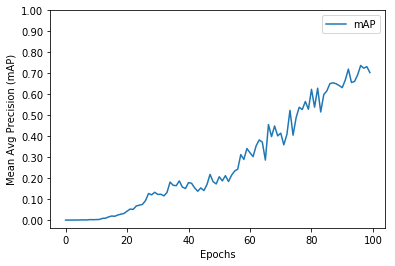

In [25]:
plot_object_detection_log(od_model, 'mAP tracking for job: ' + od_model._current_job_name)

# Host the model

Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This lets us make predictions (or inferences) from the model. Note that we don't have to host using the same type of instance that we used to train. Training is a prolonged and compute heavy job with different compute and memory requirements that hosting typically does not. In our case we chose the `ml.p3.2xlarge` instance to train, but we choose to host the model on the less expensive cpu instance, `ml.m4.xlarge`. The endpoint deployment takes several minutes, and can be accomplished as follows:

In [26]:
%%time
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: object-detection-2019-01-20-15-30-48-920
INFO:sagemaker:Creating endpoint with name object-detection-2019-01-20-15-19-31-100


---------------------------------------------------------------------------------------!CPU times: user 465 ms, sys: 75.4 ms, total: 540 ms
Wall time: 7min 21s


# Test the model

Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference.  The results of a call to the inference endpoint are in a format that is similar to the .lst format, with the addition of a confidence score for each detected object. The format of the output can be represented as `[class_index, confidence_score, xmin, ymin, xmax, ymax]`. Typically, we don't visualize low-confidence predictions.

We have provided a script to easily visualize the detection outputs. You can visulize the high-confidence preditions with bounding box by filtering out low-confidence detections using the script below:

In [27]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img = mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width  = img.shape[1]
        colors = dict()
        num_detections = 0
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            num_detections += 1
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id], linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            print('{},{}'.format(class_name,score))
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')

        print('Number of detections: ' + str(num_detections))
        plt.show()

Now we use our endpoint to try to detect objects within an image. Since the image is a jpeg, we use the appropriate content_type to run the prediction. The endpoint returns a JSON object that we can simply load and peek into. We have packaged the prediction code into a function to make it easier to test other images.

In [28]:
OBJECT_CATEGORIES = classes_df['class_id'].values.tolist()

def show_bird_prediction(filename, ep, thresh=0.30):
    b = ''
    with open(filename, 'rb') as image:
        f = image.read()
        b = bytearray(f)
    endpoint_response = runtime.invoke_endpoint(EndpointName=ep,
                                           ContentType='image/jpeg',
                                           Body=b)
    results = endpoint_response['Body'].read()
    detections = json.loads(results)
    visualize_detection(filename, detections['prediction'], OBJECT_CATEGORIES, thresh)

Here we download images that the algorithm has not yet seen.

In [29]:
!wget -q -O multi-goldfinch-1.jpg https://t3.ftcdn.net/jpg/01/44/64/36/500_F_144643697_GJRUBtGc55KYSMpyg1Kucb9yJzvMQooW.jpg
!wget -q -O northern-flicker-1.jpg https://cdn.pixabay.com/photo/2018/07/16/22/01/northern-flicker-3543017_960_720.jpg
!wget -q -O northern-cardinal-1.jpg https://cdn.pixabay.com/photo/2013/03/19/04/42/bird-94957_960_720.jpg
!wget -q -O blue-jay-1.jpg https://upload.wikimedia.org/wikipedia/commons/0/04/Cyanocitta-cristata-004.jpg
!wget -q -O hummingbird-1.jpg http://res.freestockphotos.biz/pictures/17/17875-hummingbird-close-up-pv.jpg

068.Ruby_throated_Hummingbird,0.5188482999801636
Number of detections: 1


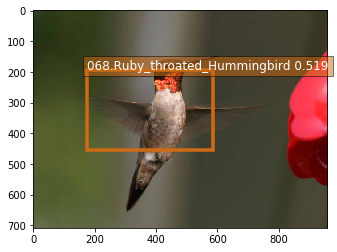

073.Blue_Jay,0.31995150446891785
Number of detections: 1


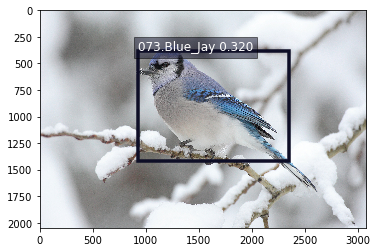

047.American_Goldfinch,0.7009504437446594
047.American_Goldfinch,0.46756765246391296
Number of detections: 2


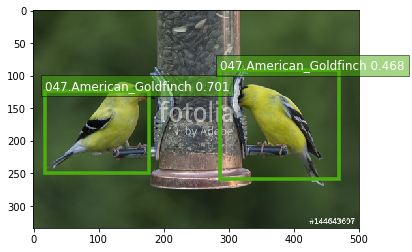

Number of detections: 0


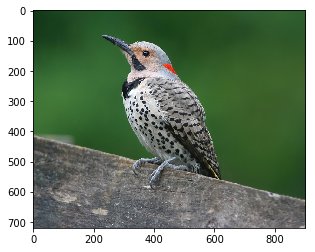

017.Cardinal,0.5781581997871399
Number of detections: 1


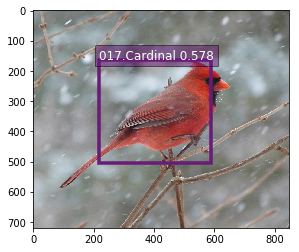

In [30]:
def test_model():
    show_bird_prediction('hummingbird-1.jpg', object_detector.endpoint)
    show_bird_prediction('blue-jay-1.jpg', object_detector.endpoint)
    show_bird_prediction('multi-goldfinch-1.jpg', object_detector.endpoint)
    show_bird_prediction('northern-flicker-1.jpg', object_detector.endpoint)
    show_bird_prediction('northern-cardinal-1.jpg', object_detector.endpoint)

test_model()

# Clean up

In [31]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)

INFO:sagemaker:Deleting endpoint with name: object-detection-2019-01-20-15-19-31-100


# Improve the model

## Define Function to Flip the Images Horizontally (on the X Axis)

In [32]:
from PIL import Image

def flip_images():
    print('Flipping images...')
    
    SIZE_COLS  = ['idx','width','height']
    IMAGE_COLS = ['image_pretty_name','image_file_name']
    LABEL_COLS = ['image_pretty_name','class_id']
    BBOX_COLS  = ['image_pretty_name', 'x_abs', 'y_abs', 'bbox_width', 'bbox_height']
    SPLIT_COLS = ['image_pretty_name', 'is_training_image']

    images_df = pd.read_csv(BASE_DIR + 'images.txt',
                            sep=' ', names=IMAGE_COLS, header=None)
    image_class_labels_df = pd.read_csv(BASE_DIR + 'image_class_labels.txt',
                            sep=' ', names=LABEL_COLS, header=None)
    bboxes_df = pd.read_csv(BASE_DIR + 'bounding_boxes.txt',
                            sep=' ', names=BBOX_COLS, header=None)
    split_df = pd.read_csv(BASE_DIR + 'train_test_split.txt',
                            sep=' ', names=SPLIT_COLS, header=None)

    NUM_ORIGINAL_IMAGES = images_df.shape[0]

    rows_list        = []
    bbox_rows_list   = []
    size_rows_list   = []
    label_rows_list  = []
    split_rows_list  = []

    idx = 0

    full_df = images_df.copy()
    full_df.reset_index(inplace=True)
    full_df = pd.merge(full_df, image_class_labels_df, on='image_pretty_name')
    full_df = pd.merge(full_df, bboxes_df, on='image_pretty_name')
    full_df = pd.merge(full_df, split_df, on='image_pretty_name')
    full_df.sort_values(by=['index'], inplace=True)

    if SAMPLE_ONLY:
        # grab a small subset of species for testing
        criteria = full_df['class_id'].isin(CLASSES)
        full_df = full_df[criteria]

    for rel_image_fn in full_df['image_file_name']:
        idx += 1
        full_img_content = full_df[(full_df.image_file_name == rel_image_fn)]

        class_id = full_img_content.iloc[0].class_id

        img = Image.open(IMAGES_DIR + rel_image_fn)

        width, height = img.size

        new_idx = idx + NUM_ORIGINAL_IMAGES

        flip_core_file_name = rel_image_fn[:-4] + '_flip.jpg'
        flip_full_file_name = IMAGES_DIR + flip_core_file_name

        img_flip = img.transpose(Image.FLIP_LEFT_RIGHT)
        img_flip.save(flip_full_file_name)

        # append a new image
        dict = {'image_pretty_name': new_idx, 'image_file_name': flip_core_file_name}
        rows_list.append(dict)

        # append a new split, use same flag for flipped image from original image
        is_training_image = full_img_content.iloc[0].is_training_image
        split_dict = {'image_pretty_name': new_idx, 'is_training_image': is_training_image}
        split_rows_list.append(split_dict)

        # append a new image class label
        label_dict = {'image_pretty_name': new_idx, 'class_id': class_id}
        label_rows_list.append(label_dict)

        # add a size row for the original and the flipped image, same height and width
        size_dict = {'idx': idx, 'width': width, 'height': height}
        size_rows_list.append(size_dict)

        size_dict = {'idx': new_idx, 'width': width, 'height': height}
        size_rows_list.append(size_dict)

        # append bounding box for flipped image

        x_abs = full_img_content.iloc[0].x_abs
        y_abs = full_img_content.iloc[0].y_abs
        bbox_width  = full_img_content.iloc[0].bbox_width
        bbox_height = full_img_content.iloc[0].bbox_height
        flipped_x_abs = width - bbox_width - x_abs

        bbox_dict = {'image_pretty_name': new_idx, 'x_abs': flipped_x_abs,
                    'y_abs': y_abs, 'bbox_width': bbox_width, 'bbox_height': bbox_height}
        bbox_rows_list.append(bbox_dict)

    print('Done looping through original images')

    images_df = images_df.append(rows_list)
    images_df[IMAGE_COLS].to_csv(IMAGE_FILE, sep=' ', index=False, header=None)
    bboxes_df = bboxes_df.append(bbox_rows_list)
    bboxes_df[BBOX_COLS].to_csv(BBOX_FILE, sep=' ', index=False, header=None)
    split_df = split_df.append(split_rows_list)
    split_df[SPLIT_COLS].to_csv(SPLIT_FILE, sep=' ', index=False, header=None)
    sizes_df = pd.DataFrame(size_rows_list)
    sizes_df[SIZE_COLS].to_csv(SIZE_FILE, sep=' ', index=False, header=None)
    image_class_labels_df = image_class_labels_df.append(label_rows_list)
    image_class_labels_df[LABEL_COLS].to_csv(LABEL_FILE, sep=' ', index=False, header=None)

    print('Done saving metadata in text files')

## Re-train the model with the expanded dataset

Flipping images...
Done looping through original images
Done saving metadata in text files
Species 017.Cardinal has 114 images.


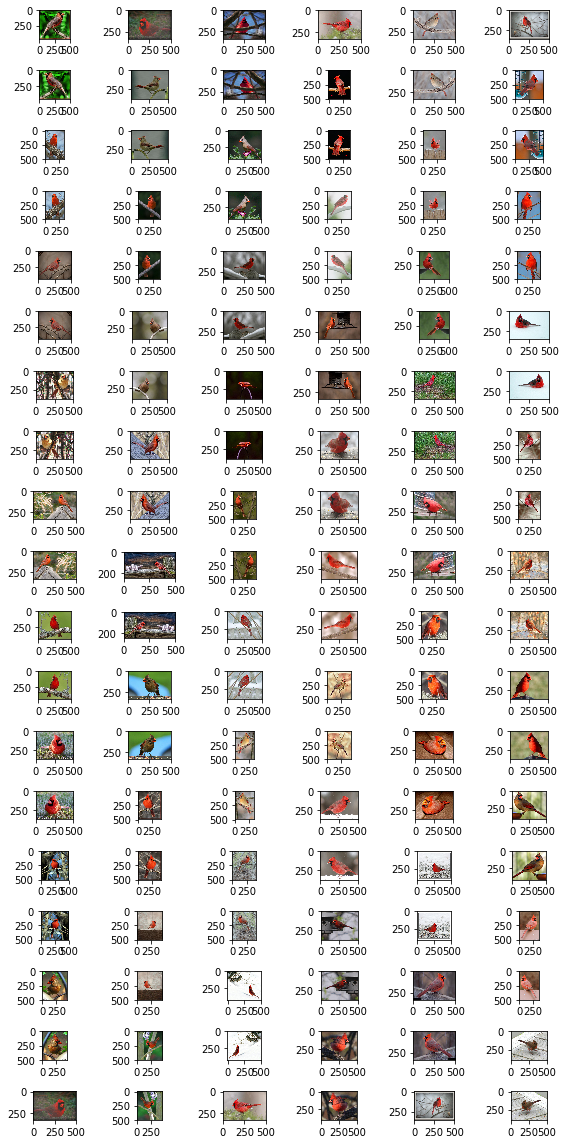

Generating a file containing image sizes...
Image sizes:
   height  idx  width
0     335    1    500
1     336    2    500
2     347    3    500
3     500    4    415
4     380    5    331
CUB_200_2011/images_with_flip.txt
num images total: 12085
num train: 300
num val: 294
Creating .rec file from /home/ec2-user/SageMaker/birds_ssd_sample_train.lst in /home/ec2-user/SageMaker
multiprocessing not available, fall back to single threaded encoding
time: 0.006188392639160156  count: 0
Creating .rec file from /home/ec2-user/SageMaker/birds_ssd_sample_val.lst in /home/ec2-user/SageMaker
multiprocessing not available, fall back to single threaded encoding
time: 0.0052814483642578125  count: 0


INFO:sagemaker:Creating training-job with name: object-detection-2019-01-20-15-39-16-509


num classes: 5, num training images: 300
2019-01-20 15:39:16 Starting - Starting the training job...
2019-01-20 15:39:22 Starting - Launching requested ML instances......
2019-01-20 15:40:27 Starting - Preparing the instances for training......
2019-01-20 15:41:26 Downloading - Downloading input data
2019-01-20 15:41:26 Training - Downloading the training image...
2019-01-20 15:42:16 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[01/20/2019 15:42:19 INFO 139754992293696] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'ea

[01/20/2019 15:42:55 WARNING 139754992293696] Expected number of batches: 18, did not match the number of batches processed: 19. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:42:55 INFO 139754992293696] #quality_metric: host=algo-1, epoch=1, batch=19 train cross_entropy <loss>=(1.82356173364)
[01/20/2019 15:42:55 INFO 139754992293696] #quality_metric: host=algo-1, epoch=1, batch=19 train smooth_l1 <loss>=(0.654022570318)
[01/20/2019 15:42:55 INFO 139754992293696] Round of batches complete
[01/20/2019 15:42:55 INFO 139754992293696] Updated the metrics
[01/20/2019 15:42:58 INFO 139754992293696] #quality_metric: host=algo-1, epoch=1, validation mAP <score>=(0.000204835303656)
[01/20/2019 15:42:58 INFO 139754992293696] Updating the best model with validation-mAP=0.000204835303656
[01/20/2019 15:42:58 INFO 139754992293696] Saved checkpoint to "/opt/ml/model/mode

[01/20/2019 15:43:37 WARNING 139754992293696] Expected number of batches: 18, did not match the number of batches processed: 19. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:43:37 INFO 139754992293696] #quality_metric: host=algo-1, epoch=6, batch=19 train cross_entropy <loss>=(1.66433982279)
[01/20/2019 15:43:37 INFO 139754992293696] #quality_metric: host=algo-1, epoch=6, batch=19 train smooth_l1 <loss>=(0.628964256217)
[01/20/2019 15:43:37 INFO 139754992293696] Round of batches complete
[01/20/2019 15:43:38 INFO 139754992293696] Updated the metrics
[01/20/2019 15:43:40 INFO 139754992293696] #quality_metric: host=algo-1, epoch=6, validation mAP <score>=(0.0141739422379)
[01/20/2019 15:43:40 INFO 139754992293696] Updating the best model with validation-mAP=0.0141739422379
[01/20/2019 15:43:40 INFO 139754992293696] Saved checkpoint to "/opt/ml/model/model_al

[01/20/2019 15:44:20 INFO 139754992293696] #quality_metric: host=algo-1, epoch=11, batch=18 train cross_entropy <loss>=(1.24265236525)
[01/20/2019 15:44:20 INFO 139754992293696] #quality_metric: host=algo-1, epoch=11, batch=18 train smooth_l1 <loss>=(0.587722530405)
[01/20/2019 15:44:20 INFO 139754992293696] Round of batches complete
[01/20/2019 15:44:20 INFO 139754992293696] Updated the metrics
[01/20/2019 15:44:23 INFO 139754992293696] #quality_metric: host=algo-1, epoch=11, validation mAP <score>=(0.0735802394186)
[01/20/2019 15:44:23 INFO 139754992293696] Updating the best model with validation-mAP=0.0735802394186
[01/20/2019 15:44:23 INFO 139754992293696] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[01/20/2019 15:44:23 INFO 139754992293696] #progress_metric: host=algo-1, completed 12 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 

[01/20/2019 15:45:11 WARNING 139754992293696] Expected number of batches: 18, did not match the number of batches processed: 19. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:45:11 INFO 139754992293696] #quality_metric: host=algo-1, epoch=17, batch=19 train cross_entropy <loss>=(0.974592884343)
[01/20/2019 15:45:11 INFO 139754992293696] #quality_metric: host=algo-1, epoch=17, batch=19 train smooth_l1 <loss>=(0.532394922768)
[01/20/2019 15:45:11 INFO 139754992293696] Round of batches complete
[01/20/2019 15:45:11 INFO 139754992293696] Updated the metrics
[01/20/2019 15:45:14 INFO 139754992293696] #quality_metric: host=algo-1, epoch=17, validation mAP <score>=(0.141354910947)
[01/20/2019 15:45:14 INFO 139754992293696] #progress_metric: host=algo-1, completed 18 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 

[01/20/2019 15:46:01 INFO 139754992293696] #quality_metric: host=algo-1, epoch=23, batch=18 train cross_entropy <loss>=(0.916173628327)
[01/20/2019 15:46:01 INFO 139754992293696] #quality_metric: host=algo-1, epoch=23, batch=18 train smooth_l1 <loss>=(0.481907768887)
[01/20/2019 15:46:01 INFO 139754992293696] Round of batches complete
[01/20/2019 15:46:01 INFO 139754992293696] Updated the metrics
[01/20/2019 15:46:03 INFO 139754992293696] #quality_metric: host=algo-1, epoch=23, validation mAP <score>=(0.195647694592)
[01/20/2019 15:46:03 INFO 139754992293696] #progress_metric: host=algo-1, completed 24 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max

[01/20/2019 15:46:43 WARNING 139754992293696] Expected number of batches: 18, did not match the number of batches processed: 19. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:46:43 INFO 139754992293696] #quality_metric: host=algo-1, epoch=28, batch=19 train cross_entropy <loss>=(0.895927432843)
[01/20/2019 15:46:43 INFO 139754992293696] #quality_metric: host=algo-1, epoch=28, batch=19 train smooth_l1 <loss>=(0.450229602876)
[01/20/2019 15:46:43 INFO 139754992293696] Round of batches complete
[01/20/2019 15:46:43 INFO 139754992293696] Updated the metrics
[01/20/2019 15:46:46 INFO 139754992293696] #quality_metric: host=algo-1, epoch=28, validation mAP <score>=(0.291494837934)
[01/20/2019 15:46:46 INFO 139754992293696] Updating the best model with validation-mAP=0.291494837934
[01/20/2019 15:46:46 INFO 139754992293696] Saved checkpoint to "/opt/ml/model/model_

[01/20/2019 15:47:25 WARNING 139754992293696] Expected number of batches: 18, did not match the number of batches processed: 19. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:47:25 INFO 139754992293696] #quality_metric: host=algo-1, epoch=33, batch=19 train cross_entropy <loss>=(0.869296762395)
[01/20/2019 15:47:25 INFO 139754992293696] #quality_metric: host=algo-1, epoch=33, batch=19 train smooth_l1 <loss>=(0.413352913455)
[01/20/2019 15:47:25 INFO 139754992293696] Round of batches complete
[01/20/2019 15:47:25 INFO 139754992293696] Updated the metrics
[01/20/2019 15:47:28 INFO 139754992293696] #quality_metric: host=algo-1, epoch=33, validation mAP <score>=(0.456950375389)
[01/20/2019 15:47:28 INFO 139754992293696] Updating the best model with validation-mAP=0.456950375389
[01/20/2019 15:47:28 INFO 139754992293696] Saved checkpoint to "/opt/ml/model/model_

[01/20/2019 15:48:07 WARNING 139754992293696] Expected number of batches: 18, did not match the number of batches processed: 19. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:48:07 INFO 139754992293696] #quality_metric: host=algo-1, epoch=38, batch=19 train cross_entropy <loss>=(0.855655408778)
[01/20/2019 15:48:07 INFO 139754992293696] #quality_metric: host=algo-1, epoch=38, batch=19 train smooth_l1 <loss>=(0.3934486965)
[01/20/2019 15:48:07 INFO 139754992293696] Round of batches complete
[01/20/2019 15:48:07 INFO 139754992293696] Updated the metrics
[01/20/2019 15:48:10 INFO 139754992293696] #quality_metric: host=algo-1, epoch=38, validation mAP <score>=(0.456828582752)
[01/20/2019 15:48:10 INFO 139754992293696] #progress_metric: host=algo-1, completed 39 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.

[01/20/2019 15:48:48 INFO 139754992293696] #quality_metric: host=algo-1, epoch=43, batch=18 train cross_entropy <loss>=(0.803888210564)
[01/20/2019 15:48:48 INFO 139754992293696] #quality_metric: host=algo-1, epoch=43, batch=18 train smooth_l1 <loss>=(0.391414747809)
[01/20/2019 15:48:48 INFO 139754992293696] Round of batches complete
[01/20/2019 15:48:48 INFO 139754992293696] Updated the metrics
[01/20/2019 15:48:51 INFO 139754992293696] #quality_metric: host=algo-1, epoch=43, validation mAP <score>=(0.612713717974)
[01/20/2019 15:48:51 INFO 139754992293696] #progress_metric: host=algo-1, completed 44 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max

[01/20/2019 15:49:29 WARNING 139754992293696] Expected number of batches: 18, did not match the number of batches processed: 19. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:49:29 INFO 139754992293696] #quality_metric: host=algo-1, epoch=48, batch=19 train cross_entropy <loss>=(0.772119374802)
[01/20/2019 15:49:29 INFO 139754992293696] #quality_metric: host=algo-1, epoch=48, batch=19 train smooth_l1 <loss>=(0.372086346907)
[01/20/2019 15:49:29 INFO 139754992293696] Round of batches complete
[01/20/2019 15:49:29 INFO 139754992293696] Updated the metrics
[01/20/2019 15:49:33 INFO 139754992293696] #quality_metric: host=algo-1, epoch=48, validation mAP <score>=(0.687780867296)
[01/20/2019 15:49:33 INFO 139754992293696] #progress_metric: host=algo-1, completed 49 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 

[01/20/2019 15:50:11 WARNING 139754992293696] Expected number of batches: 18, did not match the number of batches processed: 19. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:50:11 INFO 139754992293696] #quality_metric: host=algo-1, epoch=53, batch=19 train cross_entropy <loss>=(0.743919186214)
[01/20/2019 15:50:11 INFO 139754992293696] #quality_metric: host=algo-1, epoch=53, batch=19 train smooth_l1 <loss>=(0.347054074325)
[01/20/2019 15:50:11 INFO 139754992293696] Round of batches complete
[01/20/2019 15:50:11 INFO 139754992293696] Updated the metrics
[01/20/2019 15:50:14 INFO 139754992293696] #quality_metric: host=algo-1, epoch=53, validation mAP <score>=(0.701460540681)
[01/20/2019 15:50:14 INFO 139754992293696] #progress_metric: host=algo-1, completed 54 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 

[01/20/2019 15:50:52 WARNING 139754992293696] Expected number of batches: 18, did not match the number of batches processed: 19. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:50:52 INFO 139754992293696] #quality_metric: host=algo-1, epoch=58, batch=19 train cross_entropy <loss>=(0.734925269143)
[01/20/2019 15:50:52 INFO 139754992293696] #quality_metric: host=algo-1, epoch=58, batch=19 train smooth_l1 <loss>=(0.331293023559)
[01/20/2019 15:50:52 INFO 139754992293696] Round of batches complete
[01/20/2019 15:50:52 INFO 139754992293696] Updated the metrics
[01/20/2019 15:50:55 INFO 139754992293696] #quality_metric: host=algo-1, epoch=58, validation mAP <score>=(0.812896214783)
[01/20/2019 15:50:55 INFO 139754992293696] Updating the best model with validation-mAP=0.812896214783
[01/20/2019 15:50:55 INFO 139754992293696] Saved checkpoint to "/opt/ml/model/model_

[01/20/2019 15:51:33 INFO 139754992293696] #quality_metric: host=algo-1, epoch=63, batch=18 train cross_entropy <loss>=(0.708773126531)
[01/20/2019 15:51:33 INFO 139754992293696] #quality_metric: host=algo-1, epoch=63, batch=18 train smooth_l1 <loss>=(0.288949411216)
[01/20/2019 15:51:33 INFO 139754992293696] Round of batches complete
[01/20/2019 15:51:33 INFO 139754992293696] Updated the metrics
[01/20/2019 15:51:36 INFO 139754992293696] #quality_metric: host=algo-1, epoch=63, validation mAP <score>=(0.83098030992)
[01/20/2019 15:51:36 INFO 139754992293696] Updating the best model with validation-mAP=0.83098030992
[01/20/2019 15:51:36 INFO 139754992293696] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[01/20/2019 15:51:36 INFO 139754992293696] #progress_metric: host=algo-1, completed 64 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0

[01/20/2019 15:52:15 WARNING 139754992293696] Expected number of batches: 18, did not match the number of batches processed: 19. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:52:15 INFO 139754992293696] #quality_metric: host=algo-1, epoch=68, batch=19 train cross_entropy <loss>=(0.692055903546)
[01/20/2019 15:52:15 INFO 139754992293696] #quality_metric: host=algo-1, epoch=68, batch=19 train smooth_l1 <loss>=(0.292474546763)
[01/20/2019 15:52:15 INFO 139754992293696] Round of batches complete
[01/20/2019 15:52:15 INFO 139754992293696] Updated the metrics
[01/20/2019 15:52:18 INFO 139754992293696] #quality_metric: host=algo-1, epoch=68, validation mAP <score>=(0.829228597633)
[01/20/2019 15:52:18 INFO 139754992293696] #progress_metric: host=algo-1, completed 69 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 

[01/20/2019 15:52:56 WARNING 139754992293696] Expected number of batches: 18, did not match the number of batches processed: 19. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:52:56 INFO 139754992293696] #quality_metric: host=algo-1, epoch=73, batch=19 train cross_entropy <loss>=(0.679990865482)
[01/20/2019 15:52:56 INFO 139754992293696] #quality_metric: host=algo-1, epoch=73, batch=19 train smooth_l1 <loss>=(0.28109948473)
[01/20/2019 15:52:56 INFO 139754992293696] Round of batches complete
[01/20/2019 15:52:56 INFO 139754992293696] Updated the metrics
[01/20/2019 15:52:58 INFO 139754992293696] #quality_metric: host=algo-1, epoch=73, validation mAP <score>=(0.880358770902)
[01/20/2019 15:52:58 INFO 139754992293696] #progress_metric: host=algo-1, completed 74 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0

[01/20/2019 15:53:36 WARNING 139754992293696] Expected number of batches: 18, did not match the number of batches processed: 19. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:53:36 INFO 139754992293696] #quality_metric: host=algo-1, epoch=78, batch=19 train cross_entropy <loss>=(0.682481773501)
[01/20/2019 15:53:36 INFO 139754992293696] #quality_metric: host=algo-1, epoch=78, batch=19 train smooth_l1 <loss>=(0.267209770234)
[01/20/2019 15:53:36 INFO 139754992293696] Round of batches complete
[01/20/2019 15:53:36 INFO 139754992293696] Updated the metrics
[01/20/2019 15:53:39 INFO 139754992293696] #quality_metric: host=algo-1, epoch=78, validation mAP <score>=(0.825812640188)
[01/20/2019 15:53:39 INFO 139754992293696] #progress_metric: host=algo-1, completed 79 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 

[01/20/2019 15:54:16 INFO 139754992293696] #quality_metric: host=algo-1, epoch=83, batch=18 train cross_entropy <loss>=(0.612752890694)
[01/20/2019 15:54:16 INFO 139754992293696] #quality_metric: host=algo-1, epoch=83, batch=18 train smooth_l1 <loss>=(0.242970332273)
[01/20/2019 15:54:16 INFO 139754992293696] Round of batches complete
[01/20/2019 15:54:16 INFO 139754992293696] Updated the metrics
[01/20/2019 15:54:19 INFO 139754992293696] #quality_metric: host=algo-1, epoch=83, validation mAP <score>=(0.903490487684)
[01/20/2019 15:54:19 INFO 139754992293696] #progress_metric: host=algo-1, completed 84 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max

[01/20/2019 15:54:56 WARNING 139754992293696] Expected number of batches: 18, did not match the number of batches processed: 19. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:54:56 INFO 139754992293696] #quality_metric: host=algo-1, epoch=88, batch=19 train cross_entropy <loss>=(0.637090552289)
[01/20/2019 15:54:56 INFO 139754992293696] #quality_metric: host=algo-1, epoch=88, batch=19 train smooth_l1 <loss>=(0.253878800295)
[01/20/2019 15:54:56 INFO 139754992293696] Round of batches complete
[01/20/2019 15:54:56 INFO 139754992293696] Updated the metrics
[01/20/2019 15:54:59 INFO 139754992293696] #quality_metric: host=algo-1, epoch=88, validation mAP <score>=(0.909071491241)
[01/20/2019 15:54:59 INFO 139754992293696] #progress_metric: host=algo-1, completed 89 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 

[01/20/2019 15:55:36 WARNING 139754992293696] Expected number of batches: 18, did not match the number of batches processed: 19. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:55:36 INFO 139754992293696] #quality_metric: host=algo-1, epoch=93, batch=19 train cross_entropy <loss>=(0.605308969359)
[01/20/2019 15:55:36 INFO 139754992293696] #quality_metric: host=algo-1, epoch=93, batch=19 train smooth_l1 <loss>=(0.23149130993)
[01/20/2019 15:55:36 INFO 139754992293696] Round of batches complete
[01/20/2019 15:55:36 INFO 139754992293696] Updated the metrics
[01/20/2019 15:55:39 INFO 139754992293696] #quality_metric: host=algo-1, epoch=93, validation mAP <score>=(0.933484183988)
[01/20/2019 15:55:39 INFO 139754992293696] #progress_metric: host=algo-1, completed 94 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0

[01/20/2019 15:56:16 WARNING 139754992293696] Expected number of batches: 18, did not match the number of batches processed: 19. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/20/2019 15:56:16 INFO 139754992293696] #quality_metric: host=algo-1, epoch=98, batch=19 train cross_entropy <loss>=(0.591301052807)
[01/20/2019 15:56:16 INFO 139754992293696] #quality_metric: host=algo-1, epoch=98, batch=19 train smooth_l1 <loss>=(0.232761933525)
[01/20/2019 15:56:16 INFO 139754992293696] Round of batches complete
[01/20/2019 15:56:16 INFO 139754992293696] Updated the metrics
[01/20/2019 15:56:18 INFO 139754992293696] #quality_metric: host=algo-1, epoch=98, validation mAP <score>=(0.916519402878)
[01/20/2019 15:56:18 INFO 139754992293696] #progress_metric: host=algo-1, completed 99 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 

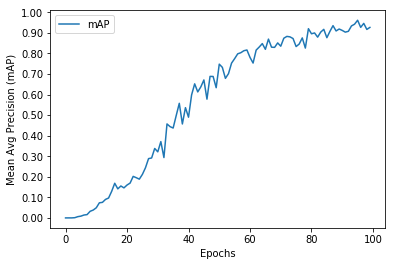

CPU times: user 54.6 s, sys: 4.27 s, total: 58.9 s
Wall time: 19min 49s


In [33]:
%%time

BBOX_FILE  = BASE_DIR + 'bounding_boxes_with_flip.txt'
IMAGE_FILE = BASE_DIR + 'images_with_flip.txt'
LABEL_FILE = BASE_DIR + 'image_class_labels_with_flip.txt'
SIZE_FILE  = BASE_DIR + 'sizes_with_flip.txt'
SPLIT_FILE = BASE_DIR + 'train_test_split_with_flip.txt'

# add a set of flipped images
flip_images()

# show the new full set of images for a species
show_species('017.Cardinal')

# create new sizes file
gen_image_size_file()

# re-create and re-deploy the RecordIO files with the updated set of images
train_df, val_df = gen_list_files()
!python tools/im2rec.py --resize $RESIZE_SIZE --pack-label birds_ssd_sample $BASE_DIR/images/
sess.upload_data(path='birds_ssd_sample_train.rec', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='birds_ssd_sample_val.rec', bucket=bucket, key_prefix=validation_channel)

# account for the new number of training images
set_hyperparameters(100, '33,67')

# re-train
od_model.fit(inputs=data_channels, logs=True)

# check out the new accuracy
plot_object_detection_log(od_model, 'mAP tracking for job: ' + od_model._current_job_name)

## Re-deploy and test

INFO:sagemaker:Creating model with name: object-detection-2019-01-20-15-58-09-478
INFO:sagemaker:Creating endpoint with name object-detection-2019-01-20-15-39-16-509


--------------------------------------------------------------------------!068.Ruby_throated_Hummingbird,0.8781362175941467
Number of detections: 1


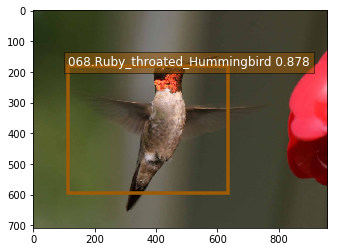

073.Blue_Jay,0.8672788143157959
Number of detections: 1


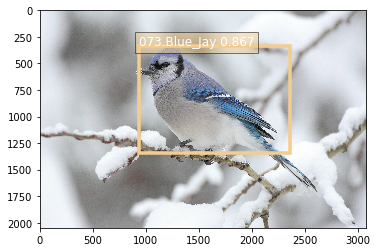

047.American_Goldfinch,0.9948439598083496
047.American_Goldfinch,0.9840790629386902
Number of detections: 2


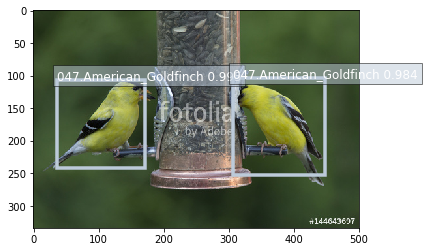

036.Northern_Flicker,0.4236140251159668
Number of detections: 1


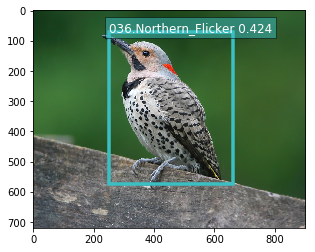

017.Cardinal,0.8556680679321289
Number of detections: 1


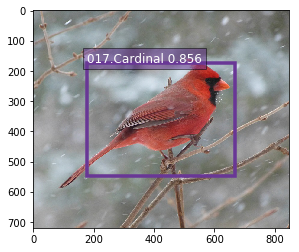

In [34]:
# host the updated model
object_detector = od_model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

# test the new model
test_model()

## Final cleanup

In [35]:
# delete the new endpoint
sagemaker.Session().delete_endpoint(object_detector.endpoint)

INFO:sagemaker:Deleting endpoint with name: object-detection-2019-01-20-15-39-16-509
